#### We have a couple of objectives with this notebook:

1. Find the optimal resolution value for the simulation by finding at which resolution the transmission values tend to converge for a range of pillar radii
2. Gain some confidence in our implementation of the simulation with periodic boundary conditions.

One caveat: We're using until=50 to run these simulations, which is lower than the standard value we used in `single_pillar_sim`, which was 200. As a result, we're seeing lower transmission values as radius increases. We did this to cut down on simulation time - We're not necessarily looking for the "true" values in this experiment - just making sure that we have consistentness across the single_pillar sim and the explicit 3x3 sim.

### Methodology:

In a docker container with mpi_meep installed, navigate to `develop/code/general_3x3/supplementary/resolution_study`.

From here, execute `mpirun --allow-run-as-root -np {num_cores} python3 main.py -config config.yaml -resolution {resolution}`

Or use the bash script, `run.sh` to execute the command for a range of resolution values (Hint: I used 32 cores for resolutions 15-60, and 56 cores for resolutions 70-120)

This script executes the single pillar sim experiment on 8 radii in the range 75-250 nm. For each simulation, the radius is repeated for a 3x3 neighborhood, which should be equivalent to a single pillar sim where only one pillar is explicitly built. Transmission values are recorded for each simulation.

Transmission values get written to `transmission-LPA.csv`.

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import helpers

root = "transmission_data"

In [3]:
# We are grabbing the transmission values for an explicitly single pillar simulation to compare to our 3x3 results. These values were obtained from code at the single_pillar_sim repo

# This is for resolution = 20
#single_pillar_trans = [0.99877507, 0.99639401, 0.98610354, 0.93417613, 0.93371424, 0.94543721, 0.87858209, 0.89464593] # until = 200
single_pillar_trans = [0.99861091, 0.994073, 0.97258366, 0.88080032, 0.81657727, 0.85404508, 0.81402319, 0.73392641] # until = 50
single_pillar_radii = [0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

In [4]:
df = pd.read_csv(os.path.join(root, "transmission-LPA.csv")) 

In [5]:
num_resolutions = df['Resolution'].nunique()
colors = helpers.get_colors(num_resolutions)

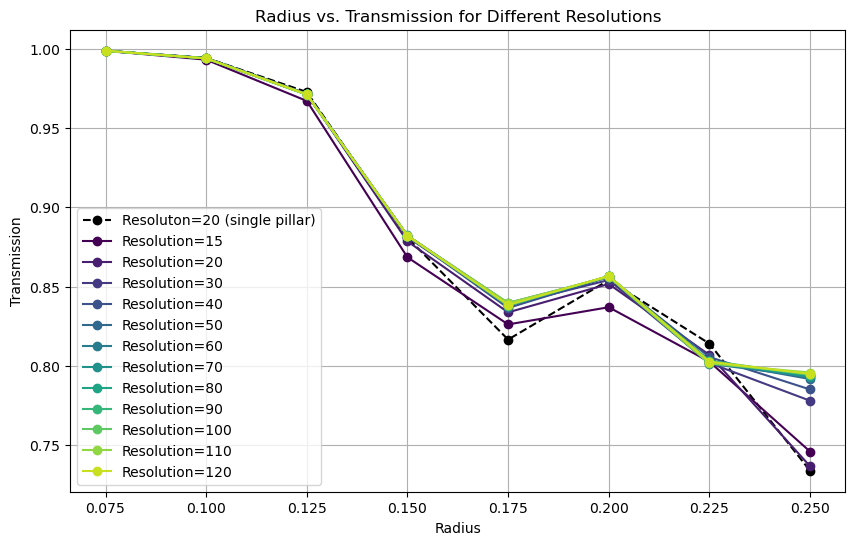

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(single_pillar_radii, single_pillar_trans, linestyle='--', marker='o', color='black', label="Resoluton=20 (single pillar)")

for i, resolution in enumerate(df['Resolution'].unique()):
    subset = df[df['Resolution'] == resolution]
    plt.plot(subset['Radius'], subset['Transmission'], marker='o', color=colors[i], label=f'Resolution={resolution}')

# Add labels and legend
plt.xlabel('Radius')
plt.ylabel('Transmission')
plt.title('Radius vs. Transmission for Different Resolutions')
plt.legend()
plt.grid(True)

Recalling our objectives: 

1. We can visually see that the simulations converge to a value around resolution = 60 or so. We'll do a little more quantitative work in a minute to get some additional confidence about that value.
2. We can see that the single pillar res = 20 and Resolution 20 graphs are just about exactly the same - So we feel pretty good about the extension of a 3x3 with identical pillars to the LPA single pillar sim.

In [7]:
def calculate_convergence(df, resolution_col, value_col):
    resolutions = df[resolution_col].unique()
    differences = []
    for i in range(1, len(resolutions)):
        prev_res = df[df[resolution_col] == resolutions[i-1]]
        curr_res = df[df[resolution_col] == resolutions[i]]
        diff = np.abs(curr_res[value_col].values - prev_res[value_col].values)
        differences.append(diff.mean())
    return resolutions, differences

resolutions, mean_differences = calculate_convergence(df, 'Resolution', 'Transmission')
print("Mean differences between consecutive resolutions:", mean_differences)

Mean differences between consecutive resolutions: [0.00645961159522751, 0.0071369873392914535, 0.00198964815631833, 0.0015308814884102268, 0.0005778342633050437, 0.0005963606792316056, 0.0005453467199198897, 0.0004083444659403468, 0.0003120432093438458, 0.000476715089683194, 0.0005515740776963207]


Text(0, 0.5, 'Mean delta across simulations')

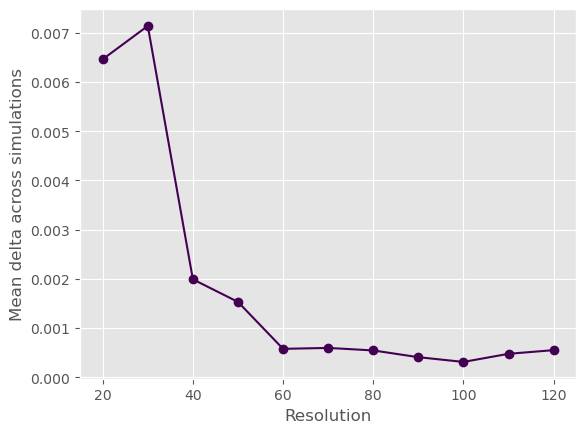

In [8]:
plt.style.use("ggplot")
fig, ax = plt.subplots()

ax.plot(resolutions[1:], mean_differences, marker='o', color=colors[0])  # We're not including the first value in `resolutions` becuase we are plotting differences
ax.set_xlabel("Resolution")
ax.set_ylabel("Mean delta across simulations")

#### For this plot, we used calculate_convergence() to find the mean deltas for transmission values for increasing resolutions. From here, we can conclude that the simulation converges at a resolution of 60.

#### Keep in mind that this was for a continuous source, identical 3x3 pillars, with a simulation runtime of 50 fs. 

#### Suggestions for additional work: Run the simulations for `until=200`, do the study for a set of random 3x3s, use a Gaussian source.

#### The dataset created with this repo used a resolution of 80 to be safe, but based on these results, 60 may have been sufficient.